In [1]:
import pandas as pd
import numpy as np
import time
import math

import matplotlib.pyplot as plt


from collections import defaultdict
from sklearn import svm, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 

In [2]:
dev10 = pd.read_csv('./2019S1-proj2-datah_dos/dev-top100.csv')
#dev50 = pd.read_csv('./2019S1-proj2-datah_dos/dev-top50.csv')
#dev100 = pd.read_csv('./2019S1-proj2-datah_dos/dev-top100.csv')

train10 = pd.read_csv('./2019S1-proj2-datah_dos/train-top100.csv')
#train50 = pd.read_csv('./2019S1-proj2-datah_dos/train-top50.csv')
#train100 = pd.read_csv('./2019S1-proj2-datah_dos/train-top100.csv')

test10 = pd.read_csv('./2019S1-proj2-datah_dos/test-top100.csv')
#test50 = pd.read_csv('./2019S1-proj2-datah_dos/test-top50.csv')
#test100 = pd.read_csv('./2019S1-proj2-datah_dos/test-top100.csv')

In [3]:
def main(train10,dev10,test10):
    x_test0=dev10.iloc[:,1:-1]
    y_test0=dev10.iloc[:,-1]
    x_train0=train10.iloc[:,1:-1]
    y_train0=train10.iloc[:,-1]

    #print("NO PREPROCESS:------------------------------------------------------------------")
    #stacking_pre(x_train0,y_train0,x_test0,y_test0)
    #run(x_train0,y_train0,x_test0,y_test0)
    
    #reduce randomness
    print("80% randomness")
    print("Trainset")
    ntrain= preprocess1(train10)
    y_train= ntrain.iloc[:,-1]
    x_train= ntrain.iloc[:,1:-1]
    
    
    print("Preprocess: only reducing randomness in trainset-----------------------------------")
    stacking_pre(x_train,y_train,x_test0,y_test0)
    run(x_train,y_train,x_test0,y_test0)
    
    print("Devset")
    ndev = preprocess1(dev10)
    y_test= ndev.iloc[:,-1]
    x_test= ndev.iloc[:,1:-1]
    print("Preprocess: reducing randomness in trainset and devset-----------------------------")
    stacking_pre(x_train,y_train,x_test,y_test)
    run(x_train,y_train,x_test,y_test)

    '''
    #mutual information feature selection
    mi_col_list=preprocess_mi(x_train,y_train)
    mi_dtrain = x_train[mi_col_list]
    mi_dtest = x_test[mi_col_list]
    print("Preprocess: mutual information feature selection----------------------------------")
    run(mi_dtrain,y_train,mi_dtest,y_test)
    
    #variance(ssssss) feature selection
    vtrain,new_columns=preprocess4(ntrain)
    vdev = ndev[new_columns]
    y_train= vtrain.iloc[:,-1]
    x_train= vtrain.iloc[:,1:-1]
    y_test= vdev.iloc[:,-1]
    x_test= vdev.iloc[:,1:-1]
    print('Preprocess: variance(ssssss) feature selection------------------------------------')
    run(x_train,y_train,x_test,y_test)
    
    #relate conditional probability and WLH
    dlist = pre_wlh(ntrain)
    dftest = ndev.drop(dlist,axis=1)
    df = ntrain.drop(dlist,axis=1)
    x_train=df.iloc[:,:-1]
    y_train=df.iloc[:,-1]
    x_test=dftest.iloc[:,:-1]
    y_test=dftest.iloc[:,-1]
    print('Preprocess: relate conditional probability and WLH---------------------------------')
    run(x_train,y_train,x_test,y_test)
    '''
    return 0
    
    
    

In [4]:
def run(x_train,y_train,x_test,y_test):
    
    #nb(x_train,y_train,x_test,y_test)
    #cross_vali(x_train,y_train,x_test,y_test)
    #decision_tree(x_train, y_train, x_test, y_test)
    
    #bagging(x_train,y_train,x_test,y_test)
    adaboosting(x_train, y_train, x_test, y_test)
    stacking(x_train,y_train,x_test,y_test)
    
    return 0
    

# preprocessing

In [5]:
def preprocess1(df):
    df1  =  df.copy()
    df1['Row_sum'] = df1[df1.columns[1:-1]].apply(lambda x:x.sum(),axis=1)
    
    df2 = df1[~df1['Row_sum'].isin([0])] #some attributes' values are not 0
    df3 = df1[df1['Row_sum'].isin([0])] # all attributes' values are 0
    
    df4=pd.DataFrame() # keep 0.01% of all-zero instances in each classes
    for  name, group in df3.groupby("Location"):
    
        X_train, X_test = train_test_split(group, test_size=0.5, random_state=42)
        df4= pd.concat([df4,X_test],ignore_index=True) 
    ntrain = (pd.concat([df2,df4],ignore_index=True)).drop(['Row_sum'],axis=1)
    print("Proportion of randomness in dataset:", df3.shape[0]/df1.shape[0])
    
    return ntrain
    # this part will return a new dataframe which contains all the usable instances and several random instances 

    


# Naive Bayes


In [6]:
def nb(x_train,y_train,x_test,y_test):
    gnb = GaussianNB()
    mnb = MultinomialNB()
    bnb = BernoulliNB()
    
    print("-----Naive Bayes-----")
    #without softing
    print("without softing:")
    gnb.fit(x_train, y_train)
    
    mnb.fit(x_train, y_train)
    bnb.fit(x_train, y_train)
    
    #print("GNB train score: ", gnb.score(x_train,y_train))
    #print("MNB train score: ", mnb.score(x_train,y_train))
    #print("BNB train score: ", bnb.score(x_train,y_train))
    
    print("GNB test score: %f " %gnb.score(x_test, y_test))
    print("MNB test score: %f " %mnb.score(x_test, y_test))
    print("BNB test score: %f " %bnb.score(x_test, y_test))
    
    
    #with soft adding-k
    print("with softing adding_k:")
    mnb_soft = MultinomialNB(alpha=1.0e-10)
    bnb_soft = BernoulliNB(alpha=1.0e-10)

    mnb_soft.fit(x_train, y_train)
    bnb_soft.fit(x_train, y_train)
    
    #print("MNB train score %f " %mnb_soft.score(x_train,y_train))
    #print("BNB train score %f " %bnb_soft.score(x_train,y_train))
    
    print("MNB test score %f " %mnb_soft.score(x_test, y_test))
    print("BNB test  score %f " %bnb_soft.score(x_test, y_test))
    
    #print("\n")
    
    return 0 
    

#  cross validation

In [7]:
def cross_vali(x_train,y_train,x_test,y_test):
    X = x_train
    y = y_train

    models = [DummyClassifier(strategy='most_frequent'),
              GaussianNB(),
              MultinomialNB(),
              svm.LinearSVC(),
              LogisticRegression()]
    titles = ['Zero-R',
              'GNB',
              'MNB',
              'LinearSVC',
              'Logistic Regression']

    print("-----Cross Validation with 0-R, NB, SVM, LogisticRE-----")
    for title, model in zip(titles, models):
        scores = cross_val_score(model, X, y, cv=10, n_jobs=-1)
        print(title,'cross-vali')
        print("cv accuracy: ",  np.mean(scores))
        print("cv stddev: ", np.std(scores))       
    
    return 0 

In [8]:
#KNeighborsClassifier(int(math.sqrt(train10.size)), "distance", n_jobs=-1),it  takes too long time and somtimes makes memory error

# decision tree

In [9]:
def decision_tree(x_train, y_train, x_test, y_test):
    dt = DecisionTreeClassifier(max_depth=None)
    start = time.time()
    dt.fit(x_train, y_train)
    end = time.time()
    
    print("------DecisionTree-----")
    print("cost time: ", end-start)
    #print("DT(without max depth) train score %f " %dt.score(x_train, y_train))
    print("DT(without max depth) test score %f " %dt.score(x_test, y_test))
    
    X= x_train
    y= y_train

    #try to change C to 1000 or 0.001
    #C = 1.0  # SVM regularization parameter
    models = [DecisionTreeClassifier(max_depth=1),
              #KNeighborsClassifier(n_neighbors=1),
              #KNeighborsClassifier(n_neighbors=4),
              DecisionTreeClassifier(max_depth=int(math.sqrt(len(x_train.columns)))),
              DecisionTreeClassifier(max_depth=None)]
              #svm.LinearSVC(C=C),
              #svm.SVC(kernel='rbf', gamma=0.7, C=C),
              #svm.SVC(kernel='poly', degree=3, C=C)]
    titles = ['1-R',
              #'1-Nearest Neighbour',
              #'4-Nearest Neighbour',
              'Decision Tree with max_depth',
              'Decision Tree']
              #'LinearSVC',
              #'SVM with a cubic kernel',
              #'SVM with an RBF kernel']

    title_training_acc = {}
    for title, model in zip(titles, models):
        model.fit(X, y)
        title_training_acc[title] = model.score(x_train, y_train)

    title_crossvalidation_acc = {}
    for title, model in zip(titles, models):
        title_crossvalidation_acc[title] = np.mean(cross_val_score(model, X, y, cv=10))

    for title in titles:
        print(title, ': Training Acc', title_training_acc[title], '; X-Val Acc', title_crossvalidation_acc[title])

    return 0

    
    

chi-squre feature selection

# Bagging ensemble with RandomForest

In [10]:
def bagging(x_train,y_train,x_test,y_test):
    rfc = RandomForestClassifier(n_estimators=int(math.sqrt(x_train.shape[0])),max_depth=None)
    rfc.fit(x_train, y_train)
    
    print("-----RandomForest-----")
    #print("RandomForest train score: ",rfc.score(x_train, y_train))
    print("RandomForest test score: ",rfc.score(x_test, y_test))

    bagging = BaggingClassifier(rfc,max_samples= 0.5, max_features=0.5)
    bagging.fit(x_train,y_train)
    
    print("-----Bagging-----")
    #print("Bagging trian score: ", bagging.score(x_train,y_train))
    print("bagging test score: ",bagging.score(x_test, y_test))
    
    return 0

# ADABoosting ensemble

In [11]:
def adaboosting(x_train, y_train, x_test, y_test):
    classes = sorted(list(set(y_train)))
    #ABC = AdaBoostClassifier(n_estimators=100, random_state=0)
    bdt_real = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=math.sqrt(x_train.shape[0])),
        n_estimators=600,
        learning_rate=1)
    
    '''
    bdt_discrete = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=2),
        n_estimators=600,
        learning_rate=1.5)
'''
    #ABC.fit(x_train,y_train)

    bdt_real.fit(x_train,y_train)
    #bdt_discrete.fit(x_train,y_train)
    
    print("-----ADABoosting-----")
    #print("bdt_real train score: ", bdt_real.score(x_train,y_train))
    print("ADAboosting with bdt_real test score: ", bdt_real.score(x_test,y_test))
    #print("bdt_discrete train score: ", bdt_discrete.score(x_train, y_train))
    #print("bdt_discrete test score: ", bdt_discrete.score(x_test, y_test))
    #print("ADABoosting train score: ", ABC.score(x_train,y_train))
    #print("ADABoosting test score: ", ABC.score(x_test,y_test))
    labels = bdt_real.predict(x_test)
    print(classification_report(y_test, labels, labels=classes))
    
    return 0

In [12]:
#from xgboost import XGBClassifier


# Stacking ensemble

In [13]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time
import time
import numpy as np

np.random.seed(1)

class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X)
        self.metaclassifier.fit(X_meta, y)
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        #print(yhats.shape)
        assert yhats.shape[0] == X.shape[0]
        return yhats
    
    def predict(self, X):
        X_meta = self._predict_base(X)
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)
    

'''
classifiers = [LogisticRegression(),
               MultinomialNB(alpha=1.0e-10),
               BernoulliNB(alpha=1.0e-10),
               DecisionTreeClassifier(max_depth=None)]

meta_classifier = DecisionTreeClassifier()
stacker = StackingClassifier(classifiers, meta_classifier)

stacker.fit(x_train, y_train)
print('stacker acc:', stacker.score(x_test, y_test))'''

"\nclassifiers = [LogisticRegression(),\n               MultinomialNB(alpha=1.0e-10),\n               BernoulliNB(alpha=1.0e-10),\n               DecisionTreeClassifier(max_depth=None)]\n\nmeta_classifier = DecisionTreeClassifier()\nstacker = StackingClassifier(classifiers, meta_classifier)\n\nstacker.fit(x_train, y_train)\nprint('stacker acc:', stacker.score(x_test, y_test))"

In [14]:
def stacking(x_train,y_train,x_test,y_test):
    classifiers = [SGDClassifier(loss='log',random_state=41, max_iter=500, tol=None, n_jobs=-1),
                    LogisticRegression(),
                   #MultinomialNB(alpha=1.0e-10),
                   #BernoulliNB(alpha=1.0e-10),
                   #RandomForestClassifier(n_estimators=50,max_depth=None,random_state=1),
                   ExtraTreesClassifier(n_jobs=-1, n_estimators=5, criterion="entropy")
                   
                  ]

    meta_classifier = DecisionTreeClassifier(max_depth = None)
    stacker = StackingClassifier(classifiers, meta_classifier)


    start = time.time()
    stacker.fit(x_train, y_train)
    end = time.time()
    print("time: ", end - start)
    print("-----Stacking-----")
    #print('stacker train acc:', stacker.score(x_train, y_train))
    print('stacker test acc:', stacker.score(x_test, y_test))
    
    return 0

In [15]:
def stacking(x_train,y_train,x_test,y_test):
    classifiers = [RandomForestClassifier(n_estimators=200,max_depth=None,random_state=42, n_jobs=-1),
                   LogisticRegression(n_jobs=-1, multi_class='multinomial',solver='sag',random_state= 42),
                   #MultinomialNB(alpha=1.0e-10),
                   #BernoulliNB(alpha=1.0e-10),
                   GaussianNB()
                  ]

    meta_classifier = DecisionTreeClassifier(max_depth = None)
    stacker = StackingClassifier(classifiers, meta_classifier)
    classes = sorted(list(set(y_train)))

    start = time.time()
    stacker.fit(x_train, y_train)
    end = time.time()
    
    print("-----Stacking-----")
    #print('stacker train acc:', stacker.score(x_train, y_train))
    
    print('stacker test acc:', stacker.score(x_test, y_test))
    labels = stacker.predict(x_test)
    print(classification_report(y_test, labels,labels= classes,target_names = classes))
    print("time: ", end - start)
    '''
    precision,recall, fbeta_score,support = precision_recall_fscore_support(y_test, labels,classes)
    print("Precision: ",zip(classes,precision))
    print("Recall: ", zip(classes,recall))
    print("F_score: ",zip(classes,fbeta_score))
    print("support: ", zip(classes,support))
    '''
    return 0
    

In [16]:

def stacking_pre(x_train,y_train,x_test,y_test):
    classes = sorted(list(set(y_train)))
    classifiers = [#GaussianNB(),
                   #MultinomialNB(alpha=1.0e-10),
                   #BernoulliNB(alpha=1.0e-10),
                   DecisionTreeClassifier(max_depth=1),
                   #DecisionTreeClassifier(max_depth=None),
                   #DecisionTreeClassifier(max_depth=int(math.sqrt(len(x_train.columns)))),
                   #ExtraTreesClassifier(n_jobs=-1, n_estimators=5, criterion="entropy"),
                   RandomForestClassifier(n_estimators=200,max_depth=None, n_jobs=-1),
                   
                   LogisticRegression(n_jobs=-1, multi_class='multinomial',solver='sag',random_state= 42),
                   svm.LinearSVC()#multi_class change to 'crammer_singer' did not help improve accuracy
                   #svm.SVC(kernel='rbf', gamma=0.7),
                   #svm.SVC(kernel='poly', degree=3),
                   
                   #KNeighborsClassifier(n_neighbors=1),
                   #KNeighborsClassifier(n_neighbors=4),
                   
                   #XGBClassifier(learning_rate =0.5,n_estimators=300,max_depth=5,gamma=0,subsample=0.8,)
                   ]
    titles = [#"GNB","MNB","BNB", "DT depth:1", "DT depth:none",'DT depth: sqrt',"ExtraTree",
             "One_R","RandomF","LogisticRe","SVM.LinearSVC"]
    
    for title, model in zip(titles, classifiers):
        start = time.time()
        model.fit(x_train,y_train)
        acc = model.score(x_test,y_test)
        end = time.time()
        t = end - start
        labels = model.predict(x_test)
        #print("label: ",labels)
        print(classification_report(y_test, labels, labels=classes))
        print(title,'test acc:',acc, 'time:', t)
    

In [18]:
main(train10,dev10,test10)

80% randomness
Trainset
Proportion of randomness in dataset: 0.7728416082968925
Preprocess: only reducing randomness in trainset-----------------------------------


C:\Users\Roywr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

   Brisbane       0.00      0.00      0.00      9329
  Melbourne       0.25      1.00      0.40      9329
      Perth       0.97      0.05      0.10      9329
     Sydney       0.00      0.00      0.00      9329

avg / total       0.31      0.26      0.13     37316

One_R test acc: 0.26246114267338405 time: 0.3988833427429199
             precision    recall  f1-score   support

   Brisbane       0.50      0.09      0.16      9329
  Melbourne       0.63      0.09      0.16      9329
      Perth       0.71      0.09      0.16      9329
     Sydney       0.27      0.94      0.41      9329

avg / total       0.53      0.30      0.22     37316

RandomF test acc: 0.30413227569943185 time: 28.08690309524536


C:\Users\Roywr\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


             precision    recall  f1-score   support

   Brisbane       0.27      0.90      0.41      9329
  Melbourne       0.60      0.10      0.17      9329
      Perth       0.69      0.09      0.16      9329
     Sydney       0.44      0.14      0.22      9329

avg / total       0.50      0.31      0.24     37316

LogisticRe test acc: 0.3076428341730089 time: 52.69369292259216
             precision    recall  f1-score   support

   Brisbane       0.52      0.09      0.15      9329
  Melbourne       0.61      0.10      0.17      9329
      Perth       0.69      0.09      0.16      9329
     Sydney       0.27      0.94      0.41      9329

avg / total       0.52      0.30      0.22     37316

SVM.LinearSVC test acc: 0.3039178904491371 time: 14.965989112854004
-----ADABoosting-----
ADAboosting with bdt_real test score:  0.30598134848322434
             precision    recall  f1-score   support

   Brisbane       0.51      0.09      0.16      9329
  Melbourne       0.70      0.09      

C:\Users\Roywr\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


-----Stacking-----
stacker test acc: 0.3078572194233037
             precision    recall  f1-score   support

   Brisbane       0.27      0.91      0.41      9329
  Melbourne       0.63      0.09      0.16      9329
      Perth       0.72      0.09      0.16      9329
     Sydney       0.44      0.14      0.22      9329

avg / total       0.52      0.31      0.24     37316

time:  81.02226281166077
Devset
Proportion of randomness in dataset: 0.8026583771036553
Preprocess: reducing randomness in trainset and devset-----------------------------


C:\Users\Roywr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

   Brisbane       0.00      0.00      0.00      7815
  Melbourne       0.25      1.00      0.40      7823
      Perth       0.97      0.06      0.11      7847
     Sydney       0.00      0.00      0.00      7843

avg / total       0.31      0.26      0.13     31328

One_R test acc: 0.26455566905005107 time: 0.30719828605651855
             precision    recall  f1-score   support

   Brisbane       0.27      0.89      0.41      7815
  Melbourne       0.62      0.11      0.19      7823
      Perth       0.70      0.11      0.18      7847
     Sydney       0.44      0.17      0.25      7843

avg / total       0.51      0.32      0.26     31328

RandomF test acc: 0.3177987742594484 time: 28.003047466278076


C:\Users\Roywr\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


             precision    recall  f1-score   support

   Brisbane       0.27      0.88      0.41      7815
  Melbourne       0.60      0.12      0.19      7823
      Perth       0.69      0.10      0.18      7847
     Sydney       0.44      0.17      0.25      7843

avg / total       0.50      0.32      0.26     31328

LogisticRe test acc: 0.3181179775280899 time: 50.37595534324646
             precision    recall  f1-score   support

   Brisbane       0.52      0.11      0.18      7815
  Melbourne       0.61      0.12      0.19      7823
      Perth       0.69      0.10      0.18      7847
     Sydney       0.27      0.93      0.42      7843

avg / total       0.52      0.31      0.24     31328

SVM.LinearSVC test acc: 0.31457482124616953 time: 15.450696468353271
-----ADABoosting-----
ADAboosting with bdt_real test score:  0.31380873340143
             precision    recall  f1-score   support

   Brisbane       0.50      0.11      0.18      7815
  Melbourne       0.63      0.11      0.

C:\Users\Roywr\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


-----Stacking-----
stacker test acc: 0.31821373850868234
             precision    recall  f1-score   support

   Brisbane       0.27      0.89      0.41      7815
  Melbourne       0.63      0.11      0.19      7823
      Perth       0.72      0.10      0.18      7847
     Sydney       0.44      0.17      0.24      7843

avg / total       0.52      0.32      0.26     31328

time:  80.47098588943481


0

In [17]:
from sklearn.model_selection import learning_curve
from sklearn.svm import LinearSVC
ntrain = preprocess1(train10)

x = train10.iloc[:,1:-1]
y= train10.iloc[:,-1]
x1 = ntrain.iloc[:,1:-1]
y1= ntrain.iloc[:,-1]

Proportion of randomness in dataset: 0.7728416082968925


In [7]:
estimator=LinearSVC()
train_sizes=[0.1,0.2,0.4,0.6,0.7,0.8]
train_size,train_scores,test_scores=learning_curve(estimator,x,y,cv=10,train_sizes=[0.1,0.2,0.4,0.6,0.7,0.8],shuffle=True)
new_train_scores=train_scores.mean(1)
train_std=train_scores.std()
test_std=test_scores.std()
new_test_scores=test_scores.mean(1)

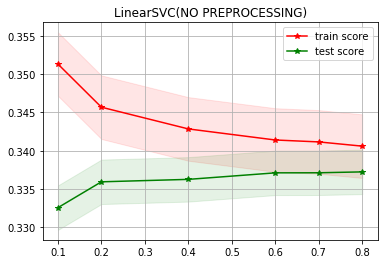

In [8]:
plt.grid()
plt.fill_between(train_sizes,new_train_scores-train_std,
                 new_train_scores+train_std,color='r',alpha=0.1)
plt.fill_between(train_sizes,new_test_scores-test_std,
                 new_test_scores+test_std,color='g',alpha=0.1)
 
plt.plot(train_sizes,new_train_scores,'*-',c='r',label='train score')
plt.plot(train_sizes,new_test_scores,'*-',c='g',label='test score')
plt.title("LinearSVC(NO PREPROCESSING)")
plt.legend(loc='best')
plt.show()


In [9]:
train_sizes = [0.2,0.4,0.6,0.7,0.8,0.9]
train_size,train_scores,test_scores=learning_curve(estimator,x1,y1,cv=10,train_sizes=[0.2,0.4,0.6,0.7,0.8,0.9],shuffle=True)
new_train_scores=train_scores.mean(1)
train_std=train_scores.std()
test_std=test_scores.std()
new_test_scores=test_scores.mean(1)


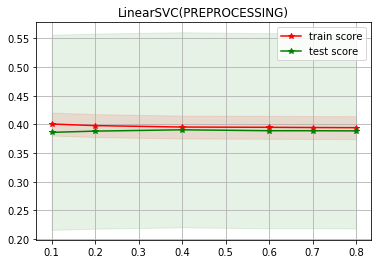

In [10]:
plt.grid()
plt.fill_between(train_sizes,new_train_scores-train_std,
                 new_train_scores+train_std,color='r',alpha=0.1)
plt.fill_between(train_sizes,new_test_scores-test_std,
                 new_test_scores+test_std,color='g',alpha=0.1)
 
plt.plot(train_sizes,new_train_scores,'*-',c='r',label='train score')
plt.plot(train_sizes,new_test_scores,'*-',c='g',label='test score')
plt.title("LinearSVC(PREPROCESSING)")
plt.legend(loc='best')
plt.show()


# plot rf

In [14]:
estimator=RandomForestClassifier(n_estimators=200,max_depth=None,random_state=42, n_jobs=-1)

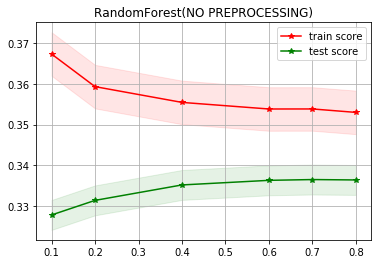

In [15]:
train_sizes = [0.1,0.2,0.4,0.6,0.7,0.8]
train_size,train_scores,test_scores=learning_curve(estimator,x,y,cv=3,train_sizes=[0.1,0.2,0.4,0.6,0.7,0.8],shuffle=True)
new_train_scores=train_scores.mean(1)
train_std=train_scores.std()
test_std=test_scores.std()
new_test_scores=test_scores.mean(1)
plt.grid()
plt.fill_between(train_sizes,new_train_scores-train_std,
                 new_train_scores+train_std,color='r',alpha=0.1)
plt.fill_between(train_sizes,new_test_scores-test_std,
                 new_test_scores+test_std,color='g',alpha=0.1)
 
plt.plot(train_sizes,new_train_scores,'*-',c='r',label='train score')
plt.plot(train_sizes,new_test_scores,'*-',c='g',label='test score')
plt.title("RandomForest(NO PREPROCESSING)")
plt.legend(loc='best')
plt.show()


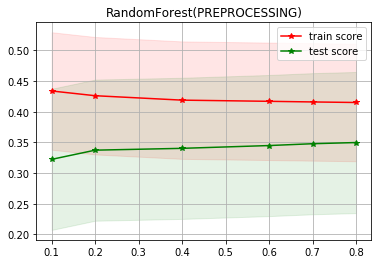

In [16]:
###preprocess
train_size,train_scores,test_scores=learning_curve(estimator,x1,y1,cv=3,train_sizes=[0.1,0.2,0.4,0.6,0.7,0.8],shuffle=True)
new_train_scores=train_scores.mean(1)
train_std=train_scores.std()
test_std=test_scores.std()
new_test_scores=test_scores.mean(1)
plt.grid()
plt.fill_between(train_sizes,new_train_scores-train_std,
                 new_train_scores+train_std,color='r',alpha=0.1)
plt.fill_between(train_sizes,new_test_scores-test_std,
                 new_test_scores+test_std,color='g',alpha=0.1)
 
plt.plot(train_sizes,new_train_scores,'*-',c='r',label='train score')
plt.plot(train_sizes,new_test_scores,'*-',c='g',label='test score')
plt.title("RandomForest(PREPROCESSING)")
plt.legend(loc='best')
plt.show()


# plot adaboost


In [17]:
estimator= AdaBoostClassifier(DecisionTreeClassifier(max_depth=math.sqrt(x.shape[0])),n_estimators=600,learning_rate=1)

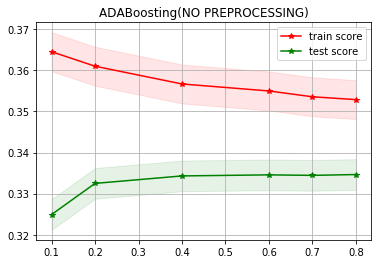

In [19]:
train_sizes = [0.1,0.2,0.4,0.6,0.7,0.8]
train_size,train_scores,test_scores=learning_curve(estimator,x,y,cv=3,train_sizes=[0.1,0.2,0.4,0.6,0.7,0.8],shuffle=True)
new_train_scores=train_scores.mean(1)
train_std=train_scores.std()
test_std=test_scores.std()
new_test_scores=test_scores.mean(1)
plt.grid()
plt.fill_between(train_sizes,new_train_scores-train_std,
                 new_train_scores+train_std,color='r',alpha=0.1)
plt.fill_between(train_sizes,new_test_scores-test_std,
                 new_test_scores+test_std,color='g',alpha=0.1)
 
plt.plot(train_sizes,new_train_scores,'*-',c='r',label='train score')
plt.plot(train_sizes,new_test_scores,'*-',c='g',label='test score')
plt.title("ADABoosting(NO PREPROCESSING)")
plt.legend(loc='best')
plt.show()



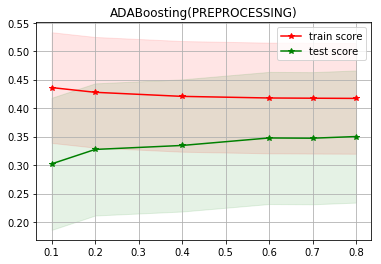

In [20]:

train_size,train_scores,test_scores=learning_curve(estimator,x1,y1,cv=3,train_sizes=[0.1,0.2,0.4,0.6,0.7,0.8],shuffle=True)
new_train_scores=train_scores.mean(1)
train_std=train_scores.std()
test_std=test_scores.std()
new_test_scores=test_scores.mean(1)
plt.grid()
plt.fill_between(train_sizes,new_train_scores-train_std,
                 new_train_scores+train_std,color='r',alpha=0.1)
plt.fill_between(train_sizes,new_test_scores-test_std,
                 new_test_scores+test_std,color='g',alpha=0.1)
 
plt.plot(train_sizes,new_train_scores,'*-',c='r',label='train score')
plt.plot(train_sizes,new_test_scores,'*-',c='g',label='test score')
plt.title("ADABoosting(PREPROCESSING)")
plt.legend(loc='best')
plt.show()


# plot stacking


# handle the raw data

In [18]:
test_raw = pd.read_csv("./2019S1-proj2-data_dos/test-raw.tsv",sep='\\t',header=None,engine='python')
test_raw=test_raw.rename(columns={0:'Instance_ID',1:'Location',2:'Text'})
#test_raw['Text']

In [19]:
#output=test_raw.copy()
#output['Location']=label

In [20]:
train_raw = pd.read_csv("./2019S1-proj2-data_dos/train-raw.tsv",sep='\\t',header=None,engine='python')
dev_raw = pd.read_csv("./2019S1-proj2-data_dos/dev-raw.tsv",sep='\\t',header=None,engine='python')
train_raw=train_raw.rename(columns={0:'Instance_ID',1:'Location',2:'Text'})
dev_raw=dev_raw.rename(columns={0:'Instance_ID',1:'Location',2:'Text'})

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.externals import joblib
#tv = TfidfVectorizer(sublinear_tf=True)
#rcf = SGDClassifier(random_state=41, max_iter=1000, tol=None, n_jobs=-1)

In [22]:
corpus_train = train_raw['Text']
corpus_dev = dev_raw['Text']
corpus_test = test_raw['Text']

#tfid  = tv.fit_transform(corpus_train)
#vct = CountVectorizer(vocabulary = None ,max_features=5000,ngram_range=(1,2))
#X_train = vct.fit_transform(corpus_train)
#y_train = train_raw['Location']
#tttt= vct.fit_transform(corpus_train)

In [23]:
#corpus_train


In [24]:
vectorizer = CountVectorizer()
count = vectorizer.fit_transform(corpus_train)  
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(count) 

In [25]:
X_train=tfidf
y_train = train_raw['Location']
count_d = vectorizer.transform(corpus_dev)
tfidf_d = transformer.transform(count_d)
X_dev = tfidf_d
y_dev= dev_raw["Location"]

In [34]:
rcf = SGDClassifier(random_state=41, max_iter=500, tol=None, n_jobs=-1)

rcf.fit(X_train,y_train)
rcf.score(X_dev,y_dev)

0.3460177939757745

In [35]:
clf = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)  #int(math.sqrt(train10.shape[0]))
clf.score(X_dev,y_dev)

0.26246114267338405

In [36]:
lr =LogisticRegression()
lr.fit(X_train,y_train)
lr.score(X_dev,y_dev)

0.3352985314610355

In [37]:
clf = DecisionTreeClassifier(max_depth=int(math.sqrt(train10.shape[0]))).fit(X_train, y_train)  
clf.score(X_dev,y_dev)

0.2988798370672098

In [ ]:
rfc = RandomForestClassifier(n_estimators=int(math.sqrt(train10.shape[0])),max_depth=100)
rfc.fit(X_train,y_train)
rfc.score(X_dev,y_dev)

In [ ]:
def stacking_raw(x_train,y_train,x_test,y_test):
    classifiers = [ExtraTreesClassifier(n_jobs=-1, n_estimators=5, criterion="entropy"),
                   LogisticRegression(n_jobs=-1,random_state= 42),
                   SGDClassifier(random_state=41, max_iter=500, tol=None, n_jobs=-1)
                   ]

    meta_classifier = DecisionTreeClassifier(max_depth = None)
    stacker = StackingClassifier(classifiers, meta_classifier)
    classes = sorted(list(set(y_train)))

    start = time.time()
    stacker.fit(x_train, y_train)
    end = time.time()
    
    
    #print('stacker train acc:', stacker.score(x_train, y_train))
    
    print('stacker test acc:', stacker.score(x_test, y_test))
    labels = stacker.predict(x_test)
    print(classification_report(y_test, labels,labels= classes,target_names = classes))
    print("time: ", end - start)

    return 0

In [ ]:
stacking_raw(X_train,y_train,X_dev,y_dev)

In [ ]:
adaboosting(X_train, y_train, X_dev, y_dev)